# Merge ETP
This notebook is used to merge the inscriptions from the ETP website and the clean ETP CSV file.

In [ ]:
!pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bs4
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from typing import Tuple, Optional
import Levenshtein

In [ ]:
csv_file = "ETP_clean.csv"
html_file = "ETP - search.htm"

## Load data

In [ ]:
cleanETP = pd.read_csv(csv_file, index_col = 0)
cleanETP

,ID,Etruscan,Translation
0,ETP 192,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris."
1,Cr 2.20,mi karkanas θahvna,I (am) the container of Karkana
2,Cm 2.46,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...
3,ETP 269,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.
4,Ta 3.2,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...
...,...,...,...
237,ERP 27,vel uθraσ | mlax,"Vel Uthra, (a) good (man)"
238,Po 4.4,śθ • velσu • lθ • c • lθ . ve[lσu] [•] inpa •...,"Shethre Velsu, son of Larth; Larth Velsu; inp..."
239,Vt 4.2,θuσuθur σelaśva θlu θupit aisece tati,"O Thusu gods (?), the sela ones, thlu (?) in ..."
240,Vs 7.25,zatlaθ : aiθas,guard of Aitha (Hades)


In [ ]:
with open(html_file) as f:
    html = BeautifulSoup(f)
print("Len:", len(html))

Len: 5


## Extract from HTML

In [ ]:
docs = html.findAll("div", {"class":"document"})
print("Documents:", len(docs))
print("Expected documents: 369")

Documents: 369
Expected documents: 369


In [ ]:
def extract_pairs(html_doc: bs4.element.Tag) -> Optional[Tuple[int, str]]:
    """
    Extract the ETP id and the text from each document

    Args:
        html_doc: bs4 tag containing the document
    Returns:
        id: ETP id as int
        text: Etruscan text
    """
    id = html_doc.findAll("h3")
    if len(id) == 0:
        print("Can't find id")
        return None
    if len(id) > 1:
        print("Multiple ids")
    try:
        id = int(id[0].text.strip().split(":")[0].split(" ")[1])
    except ValueError:
        print(f"Can't parse id: {id[0].text}")

    text = html_doc.findAll("div", {"class": "text"})
    if len(text) == 0:
        print(f"{id}: Can't find text")
        return None
    if len(text) > 1:
        print(f"{id}: Multiple texts")
    text = text[0].text.strip()
    return id, text

In [ ]:
pairs = [extract_pairs(i) for i in docs]
pairs[:5]

[(1, 'larθ : raplni :'),
 (2, 'mi v[e]nelus vefunas'),
 (3, 'larθi : peθnei : frauniσa \n    laθinial : sec :'),
 (4, '[ - - v]enel p[ - - - ]'),
 (5, 'lariσ')]

In [ ]:
htmlETP = pd.DataFrame(pairs, columns=["ID","Etruscan"])
htmlETP

,ID,Etruscan
0,1,larθ : raplni :
1,2,mi v[e]nelus vefunas
2,3,larθi : peθnei : frauniσa \n laθinial : sec :
3,4,[ - - v]enel p[ - - - ]
4,5,lariσ
...,...,...
364,365,[ – – – ]urθ[ – – – ]
365,366,[ – – – ]alv[ – – – ]
366,367,[ – – – ]tinai[ – – – ]
367,368,[ – – – ]nutas[ – – – ]


## Compute similarity

In [ ]:
def processor(s: str) -> str:
    "Clean a str for the comparison"
    s = s.replace(" ", "")  # Ignore space for distance
    s = s.replace(":", "")  # Ignore other symbols for "space"
    s = s.replace("·", "")
    s = s.replace("|", "")
    s = s.replace(".", "")
    s = s.replace("\t", "")
    s = s.replace("\n", "")  # Ignore new lines
    s = s.replace("/", "")
    s = s.replace("š", "s")  # Ignore letter's variations
    s = s.replace("'", "")
    s = s.replace("ś", "s")
    s = s.replace("ê", "e")

    return s

In [ ]:
distances = np.ones((len(cleanETP), len(htmlETP))) * np.inf

In [ ]:
tot = distances.size
with tqdm(total=tot) as pbar:
    for i, (cleanId, cleanEtr, _) in enumerate(cleanETP.iloc):
        for j, (htmlId, htmlEtr) in enumerate(htmlETP.iloc):
            distances[i, j] = Levenshtein.distance(cleanEtr, htmlEtr, processor=processor)
            pbar.update()
distances

  0%|          | 0/89298 [00:00<?, ?it/s]

array([[19., 21., 22., ..., 23., 23., 20.],
       [12., 13., 24., ..., 19., 16., 17.],
       [35., 33., 35., ..., 39., 38., 34.],
       ...,
       [27., 25., 26., ..., 29., 28., 27.],
       [ 9., 15., 23., ..., 19., 17., 16.],
       [12., 16., 24., ..., 19., 18., 18.]])

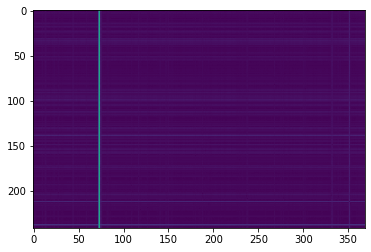

In [ ]:
plt.imshow(distances)

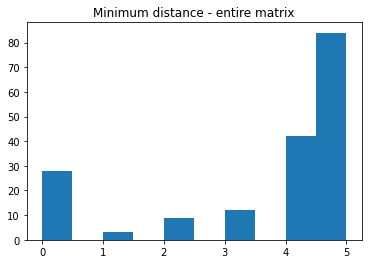

In [ ]:
plt.title("Minimum distance - entire matrix")
plt.hist(distances.flatten(), range=[0, 5])
plt.show()

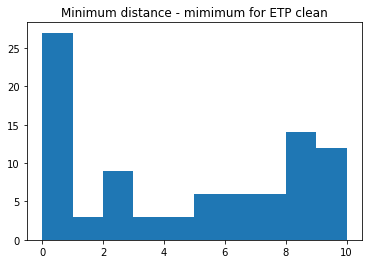

In [ ]:
plt.title("Minimum distance - mimimum for ETP clean")
plt.hist(distances.min(axis=1), range=[0, 10])
plt.show()

In [ ]:
def ask_match(cleanETP, htmlETP, dist, n = 3): 
    index_map = []
    tot = len(cleanETP)
    print("Insert number of the best matching string. \nAny non-numeric string if there is not a good match")
    try:
        for i, (cleanId, cleanEtr, _) in enumerate(cleanETP.iloc):
            top = dist[i].argsort()[:n]
            print(f"Example {i+1}/{tot}: {cleanEtr}\n")
            for j, index in enumerate(top):
                htmlId, htmlEtr = htmlETP.iloc[index]
                print(f"{j} - {htmlEtr}")
            match_ = input("Match:")
            index_map.append((i, match_))
    except KeyboardInterrupt:
        print("Interrupted")
    return index_map, i

In [ ]:
index_map, done = ask_match(cleanETP[(distances.min(axis=1) <= 10)], htmlETP, distances[(distances.min(axis=1) <= 10)])

Insert number of the best matching string. 
Any non-numeric string if there is not a good match
Example 1/89:  cleusinas : laris : larisal : clan 

0 - cleusinas : laris : larisal : clan
1 - cusinas · larθal
2 - laris : almni : larθ[al]
Match:0
Example 2/89:  mi karkanas θahvna 

0 - mi larzas atrnas
1 - mi larθia tarinas
2 - mi tarnaial
Match:
Example 3/89:  mini muluvanice tetana ve.l.ka.s.na.s. veleliiasi 

0 - mini muluvanice tetana ve.l.ka.s.na.s. veleliiasi
1 - mini muluvunike pisna perkena
2 - mi mulu venelasi velχaesi rasuniesi
Match:0
Example 4/89:  mi menervas 

0 - mi menervas
1 - mi venelus
2 - mi urqenas
Match:0
Example 5/89:  θanaχvil 

0 - θanaχti
1 - θac θva
2 - mi θanuχvilus
Match:
Example 6/89:  mi qutum karkanas 

0 - mi : σuris : cavaθas
1 - qurianas
2 - mi tarnaial
Match:
Example 7/89:  mi spanti larices 

0 - mi larices
1 - mi mutilates
2 - mi larice[s]
Match:
Example 8/89:  turis : mi : une : ame 

0 - laris
    ecnatie
1 - qurianas
2 - turuns
Match:
Example 9/89

In [ ]:
print("Done:", done)
index_map

Done: 88


[(0, '0'),
 (1, ''),
 (2, '0'),
 (3, '0'),
 (4, ''),
 (5, ''),
 (6, ''),
 (7, ''),
 (8, ''),
 (9, '0'),
 (10, ''),
 (11, ''),
 (12, ''),
 (13, ''),
 (14, ''),
 (15, ''),
 (16, ''),
 (17, ''),
 (18, ''),
 (19, ''),
 (20, ''),
 (21, ''),
 (22, ''),
 (23, '0'),
 (24, ''),
 (25, '0'),
 (26, ''),
 (27, ''),
 (28, ''),
 (29, ''),
 (30, ''),
 (31, ''),
 (32, ''),
 (33, '0'),
 (34, '0'),
 (35, '0'),
 (36, '0'),
 (37, '0'),
 (38, '0'),
 (39, '0'),
 (40, '0'),
 (41, '0'),
 (42, '0'),
 (43, '0'),
 (44, '0'),
 (45, '0'),
 (46, '0'),
 (47, ''),
 (48, ''),
 (49, '0'),
 (50, '0'),
 (51, '0'),
 (52, '0'),
 (53, '0'),
 (54, '0'),
 (55, '0'),
 (56, '0'),
 (57, ''),
 (58, '0'),
 (59, '0'),
 (60, '0'),
 (61, '0'),
 (62, '0'),
 (63, '0'),
 (64, '0'),
 (65, '0'),
 (66, '0'),
 (67, '0'),
 (68, ''),
 (69, '0'),
 (70, '0'),
 (71, '0'),
 (72, '0'),
 (73, '0'),
 (74, '0'),
 (75, '0'),
 (76, '0'),
 (77, '0'),
 (78, ''),
 (79, '0 1'),
 (80, ''),
 (81, '0'),
 (82, ''),
 (83, ''),
 (84, ''),
 (85, '0'),
 (86, ''),
 

In [ ]:
def compute_id_matches(cleanETP, htmlETP, dist, pairs):
    matches = []
    for i, j in pairs:        
        j = j.strip()
        j.split(" ")
        cleanId = cleanETP.iloc[i]["ID"]
        for n in j:            
            if len(n.strip()) > 0:                              
                n = int(n)
                htmlIndex = dist[i].argsort()[n]
                htmlId = htmlETP.iloc[htmlIndex]["ID"]
                matches.append((cleanId, htmlId))
    return matches         

In [ ]:
matches = compute_id_matches(cleanETP[(distances.min(axis=1) <= 10)], htmlETP, distances[(distances.min(axis=1) <= 10)], index_map)

In [ ]:
df = pd.DataFrame(matches, columns=["Clean ETP ID", "HTML ETP ID"])
df

,Clean ETP ID,HTML ETP ID
0,ETP 192,192
1,ETP 269,269
2,ETP 251,251
3,ETP 285,285
4,ETP 269,269
5,ETP 303,303
6,ETP 213,213
7,ETP 214,214
8,ETP 43,43
9,ETP 333,333


In [ ]:
df.to_csv("ETP_Map.csv")

## Export the final CSV

In [ ]:
map_id = pd.read_csv("ETP_Map.csv", index_col=0)

In [ ]:
htmlETP_unmatched_mask = htmlETP["ID"].apply(lambda x: x not in map_id["HTML ETP ID"])
print("New inscriptions:", htmlETP_unmatched_mask.sum())

New inscriptions: 319


In [ ]:
htmlETP_unmatched = htmlETP[htmlETP_unmatched_mask]
htmlETP_unmatched.loc[:, "ID"] = htmlETP_unmatched["ID"].apply(lambda x: f"ETP {x}")
cleanETP = cleanETP.append(htmlETP_unmatched, ignore_index=True)
cleanETP

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,ID,Etruscan,Translation
0,ETP 192,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris."
1,Cr 2.20,mi karkanas θahvna,I (am) the container of Karkana
2,Cm 2.46,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...
3,ETP 269,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.
4,Ta 3.2,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...
...,...,...,...
556,ETP 365,[ – – – ]urθ[ – – – ],NaN
557,ETP 366,[ – – – ]alv[ – – – ],NaN
558,ETP 367,[ – – – ]tinai[ – – – ],NaN
559,ETP 368,[ – – – ]nutas[ – – – ],NaN


In [ ]:
cleanETP.to_csv("ETP_clean.csv")

# Add Dates and Locations

Here we load the file with dates and loactions from the book and we had those from the website.

In [8]:
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re

In [2]:
html = "ETP - search.htm"
data = "ETP_final.xlsx"

In [5]:
df = pd.read_excel(data)
del df["Column1"]
df

,ID,City,Year - From,Year - To,Etruscan,Translation
0,ETP 192,Ager Tarquiniensis,275.0,250.0,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris."
1,Cr 2.20,Caere,675.0,650.0,mi karkanas θahvna,I (am) the container of Karkana
2,Cm 2.46,Campania,500.0,450.0,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...
3,ETP 269,NaN,625.0,600.0,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.
4,Ta 3.2,Tarquinia,580.0,580.0,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...
...,...,...,...,...,...,...
556,ETP 365,NaN,NaN,NaN,[---]urθ[---],NaN
557,ETP 366,NaN,NaN,NaN,[---]alv[---],NaN
558,ETP 367,NaN,NaN,NaN,[---]tinai[---],NaN
559,ETP 368,NaN,NaN,NaN,[---]nutas[---],NaN


In [6]:
with open(html) as f:
    html_data = BeautifulSoup(f)

In [19]:
date_re = re.compile("[0-9]+( ?- ?[0-9]+)?")

In [32]:
def extract_info(html_data):
    """
    Find ID, location and date (e.g., 450-400, 400, recent) 
    """
    docs = html_data.findAll("div", {"class":"document"})
    info = []
    for doc in docs:
        id = doc.findAll("h3")
        if len(id) == 0:
            print("Can't find id")
            return None
        if len(id) > 1:
            print("Multiple ids")
        try:
            id = id[0].text.strip().split(":")[0] # e.g., ETP 55
        except ValueError:
            print(f"Can't parse id: {id[0].text}")
            id = np.nan

        divs = doc.findAll("div")
        location = np.nan
        date_from = np.nan
        date_to = np.nan        

        for div in divs:
            tmp = div.text.strip().lower()
            if tmp.startswith("location"):
                location = div.find("a").text.strip()
                location = location.split("(")[0].strip()  # Take only the ancient name
            elif tmp.startswith("date"):    
                tmp_date = div.find("a").text.strip()
                if date_re.fullmatch(tmp_date):  # 500-450 or 500
                    tmp_date = tmp_date.split("-")                    
                    date_from = tmp_date[0].strip()
                    date_to = tmp_date[-1].strip()  # If the date is 500, the range is 500 - 500
        info.append((id, location, date_from, date_to))
    return info       

In [33]:
info = extract_info(html_data)
print(len(info))

369


In [43]:
# Interate through the list and merge (slow and easy)
for id_, loc_, from_, to_ in info:
    mask = df["ID"] == id_
    df.loc[mask, "City"] = loc_
    df.loc[mask, "Year - From"] = from_
    df.loc[mask, "Year - To"] = to_

In [44]:
df

,ID,City,Year - From,Year - To,Etruscan,Translation
0,ETP 192,Ager Tarquiniensis,275.0,250.0,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris."
1,Cr 2.20,Caere,675.0,650.0,mi karkanas θahvna,I (am) the container of Karkana
2,Cm 2.46,Campania,500.0,450.0,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...
3,ETP 269,NaN,625.0,600.0,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.
4,Ta 3.2,Tarquinia,580.0,580.0,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...
...,...,...,...,...,...,...
556,ETP 365,Ager Saenensis,600,600,[---]urθ[---],NaN
557,ETP 366,Ager Saenensis,600,600,[---]alv[---],NaN
558,ETP 367,Ager Saenensis,600,600,[---]tinai[---],NaN
559,ETP 368,Ager Faesulanus,600,575,[---]nutas[---],NaN


In [45]:
df.to_csv("ETP_final.csv")